In [1]:
import numpy as np 
import torch
import matplotlib.pyplot as plt 
import torch.nn as nn 
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image

import glob

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
DATA_DIR = os.path.join(os.getcwd(),"data/img")

### Hyper parameters

In [4]:
hr_size = 96
r = 4
beta1 = 0.9
lr = 10e-4
batch_size = 32
epochs = 20

### Custom dataset 

#### At each batch iteration, we should be able to retrieve the HR image and the LR image

In [5]:
class SRGANDataset(Dataset): 
    
    def __init__(self, folder, hr_size, stride=4): 
        self.folder = folder 
        self.hr_size = folder
        self.stride = stride
        
        self.hr_transform = transforms.Compose([
            transforms.Resize((hr_size, hr_size)), 
            transforms.ToTensor(), 
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
        self.lr_transform = transforms.Compose([
            transforms.Resize((hr_size//stride, hr_size//stride)), 
            transforms.ToTensor(), 
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
        self.files = sorted(glob.glob(folder + "/*.*"))
        
    def __getitem__(self, idx): 
        
        img_name = self.files[idx] 
        image_obj = Image.open(img_name)
        
        return {
            "hr" : self.hr_transform(image_obj), 
            "lr" : self.lr_transform(image_obj)
        }
    
    def __len__(self): 
        return len(self.files)

In [6]:
data = SRGANDataset(DATA_DIR, hr_size)
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=4)

In [7]:
def plot_both(hr_img, lr_img): 
    hr_img = np.transpose(hr_img, (1, 2, 0)) 
    lr_img = np.transpose(lr_img, (1, 2, 0))
    
    
    f, ax = plt.subplots(1,2)
    
    ax[0].imshow(hr_img)
    ax[1].imshow(lr_img)
    
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


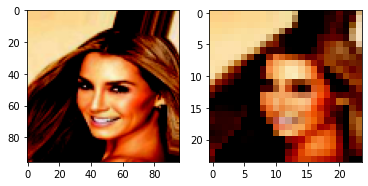

In [8]:
sample = data[0]
plot_both(sample["hr"], sample["lr"])

### Implementing the generator model

In [9]:
class ResidualBlock(nn.Module): 
    
    def __init__(self, in_c, kernel_size=3): 
        super(ResidualBlock, self).__init__()
        self.in_c = in_c
        self.kernel_size = kernel_size
        self.conv1 = nn.Conv2d(in_c, in_c, kernel_size, padding=1)
        self.bn1 = nn.BatchNorm2d(in_c)
        self.prelu = nn.PReLU() 
        self.conv2 = nn.Conv2d(in_c, in_c, kernel_size, padding=1) 
        self.bn2 = nn.BatchNorm2d(in_c)
    
    def forward(self, x): 
        identity = x 
        x = self.conv1(x) 
        x = self.bn1(x) 
        x = self.prelu(x) 
        x = self.conv2(x)
        x = self.bn2(x)
        return x + identity
    

In [10]:
from torchsummary import summary

resblock = ResidualBlock(64)
resblock.to(device)
summary(resblock, (64, 224, 224), device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]          36,928
       BatchNorm2d-2         [-1, 64, 224, 224]             128
             PReLU-3         [-1, 64, 224, 224]               1
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
Total params: 74,113
Trainable params: 74,113
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 12.25
Forward/backward pass size (MB): 122.50
Params size (MB): 0.28
Estimated Total Size (MB): 135.03
----------------------------------------------------------------


In [11]:
class UpSamplingBlock(nn.Module): 
    
    def __init__(self, in_c, out_c, kernel_size=3): 
        super(UpSamplingBlock, self).__init__()
        self.in_c = in_c
        self.out_c = out_c
        
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size) 
        # important : pixelshuffle also divide the nb for channels 
        # by 4 !!
        self.upsample = nn.PixelShuffle(2) # upsampling factor
        self.prelu = nn.PReLU()
        
    def forward(self, x): 
        
        x = self.conv1(x) 
        x = self.upsample(x) 
        x = self.prelu(x) 
        
        return x

In [12]:
upsamplingblock = UpSamplingBlock(64, 256) 
upsamplingblock.to(device)
summary(upsamplingblock, (64, 32, 32), device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 30, 30]         147,712
      PixelShuffle-2           [-1, 64, 60, 60]               0
             PReLU-3           [-1, 64, 60, 60]               1
Total params: 147,713
Trainable params: 147,713
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.25
Forward/backward pass size (MB): 5.27
Params size (MB): 0.56
Estimated Total Size (MB): 6.09
----------------------------------------------------------------


In [13]:
class Generator(nn.Module): 
    
    def __init__(self, in_c, out_c): 
        super(Generator, self).__init__()
        self.in_c = in_c 
        self.out_c = out_c
        
        self.conv1 = nn.Conv2d(3, 64, 9, padding=4)
        self.prelu1 = torch.nn.PReLU() 
        
        residuals = [] 
        
        for i in range(5): 
            residuals.append(ResidualBlock(64))
            
        self.residuals = nn.Sequential(*residuals)
        
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        upsamplings = []
        
        for i in range(2): 
            upsamplings.append(UpSamplingBlock(64, 256))
        
        self.upsampling = nn.Sequential(*upsamplings)
        
        self.conv3 = nn.Conv2d(64, 3, kernel_size=3, padding=7)
        
        
    def forward(self, x): 
        
        x = self.conv1(x) 
        identity = self.prelu1(x) 
        x = self.residuals(identity) 
        x = self.conv2(x) 
        x = self.bn2(x) 
        # residual 
        x = x + identity
        x = self.upsampling(x)
        
        x = self.conv3(x)
        
        return x

In [14]:
gnet = Generator(64, 256) 
gnet.to(device)
summary(gnet, (3, hr_size//4, hr_size//4), device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 24, 24]          15,616
             PReLU-2           [-1, 64, 24, 24]               1
            Conv2d-3           [-1, 64, 24, 24]          36,928
       BatchNorm2d-4           [-1, 64, 24, 24]             128
             PReLU-5           [-1, 64, 24, 24]               1
            Conv2d-6           [-1, 64, 24, 24]          36,928
       BatchNorm2d-7           [-1, 64, 24, 24]             128
     ResidualBlock-8           [-1, 64, 24, 24]               0
            Conv2d-9           [-1, 64, 24, 24]          36,928
      BatchNorm2d-10           [-1, 64, 24, 24]             128
            PReLU-11           [-1, 64, 24, 24]               1
           Conv2d-12           [-1, 64, 24, 24]          36,928
      BatchNorm2d-13           [-1, 64, 24, 24]             128
    ResidualBlock-14           [-1, 64,

In [15]:
class DiscConvBlock(nn.Module): 
    
    def __init__(self, in_c, out_c, stride=1): 
        super(DiscConvBlock, self).__init__()
        self.in_c = in_c
        self.stride=stride
        self.out_c = out_c
        self.conv1 = nn.Conv2d(in_c, out_c, 3, stride=stride)
        self.bn = nn.BatchNorm2d(out_c)
        self.lrelu = nn.LeakyReLU(0.2)
        
    def forward(self, x): 
        x = self.conv1(x) 
        x = self.bn(x) 
        x = self.lrelu(x)
        
        return x

class Discriminator(nn.Module): 
    
    def __init__(self, in_c, out_c): 
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(in_c, 64, 3) 
        self.lrelu = nn.LeakyReLU(0.2)
                
        self.convblocks = nn.Sequential(*[
            DiscConvBlock(64, 128, 2), 
            DiscConvBlock(128, 128, 1), 
            DiscConvBlock(128, 256, 2), 
            DiscConvBlock(256, 256, 1), 
            DiscConvBlock(256, 512, 2),
            DiscConvBlock(512, 512, 1), 
        ])
        self.fc = nn.Linear(512 * 7 * 7, 1024) 
        self.lrelu = nn.LeakyReLU(0.2) 
        self.final = nn.Linear(1024, 1) 
        self.sigmoid = torch.nn.functional.sigmoid
        
    def forward(self, x): 
        x = self.conv1(x) 
        x = self.lrelu(x)
        x = self.convblocks(x) 
        x = torch.flatten(x, 1)
        x = self.fc(x) 
        x = self.lrelu(x) 
        x = self.final(x) 
        x = self.sigmoid(x)
        
        return x
        
            
        

In [16]:
dnet = Discriminator(3, 512) 
dnet.to(device)
summary(dnet, (3, hr_size, hr_size), batch_size=batch_size, device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 64, 94, 94]           1,792
         LeakyReLU-2           [32, 64, 94, 94]               0
            Conv2d-3          [32, 128, 46, 46]          73,856
       BatchNorm2d-4          [32, 128, 46, 46]             256
         LeakyReLU-5          [32, 128, 46, 46]               0
     DiscConvBlock-6          [32, 128, 46, 46]               0
            Conv2d-7          [32, 128, 44, 44]         147,584
       BatchNorm2d-8          [32, 128, 44, 44]             256
         LeakyReLU-9          [32, 128, 44, 44]               0
    DiscConvBlock-10          [32, 128, 44, 44]               0
           Conv2d-11          [32, 256, 21, 21]         295,168
      BatchNorm2d-12          [32, 256, 21, 21]             512
        LeakyReLU-13          [32, 256, 21, 21]               0
    DiscConvBlock-14          [32, 256,

/home/valentin/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


### Important the pre-trained vgg16

In [17]:
import torchvision.models as models

vgg16 = models.vgg16(pretrained=True)

In [18]:
class VGGExtractor(nn.Module): 
    
    def __init__(self, vgg):
        super(VGGExtractor, self).__init__() 
        # extract layers
        self.vgg = vgg
        self.layer19 = list(vgg.children())[0][:36]    
        for param in self.layer19.parameters():
            param.requires_grad = False
        
    def forward(self, x):
        return self.layer19(x)

In [19]:
feature_extractor = VGGExtractor(vgg16)
feature_extractor.to(device)
summary(feature_extractor, (3, hr_size, hr_size), device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 96, 96]           1,792
            Conv2d-2           [-1, 64, 96, 96]           1,792
              ReLU-3           [-1, 64, 96, 96]               0
              ReLU-4           [-1, 64, 96, 96]               0
            Conv2d-5           [-1, 64, 96, 96]          36,928
            Conv2d-6           [-1, 64, 96, 96]          36,928
              ReLU-7           [-1, 64, 96, 96]               0
              ReLU-8           [-1, 64, 96, 96]               0
         MaxPool2d-9           [-1, 64, 48, 48]               0
        MaxPool2d-10           [-1, 64, 48, 48]               0
           Conv2d-11          [-1, 128, 48, 48]          73,856
           Conv2d-12          [-1, 128, 48, 48]          73,856
             ReLU-13          [-1, 128, 48, 48]               0
             ReLU-14          [-1, 128,

In [20]:
class GContentLoss(nn.Module): 
    
    def __init__(self, loss="MSE"): 
        # extractor 
        super(GContentLoss, self).__init__()
        self.extractor = VGGExtractor(vgg16)
        if loss == "MSE": 
            self.loss = torch.nn.MSELoss()
        elif loss == "l1": 
            self.loss = torch.nn.L1Loss()
        
    def forward(self, hr, lr): 
                
        hr_feat = self.extractor(hr)
        lr_feat = self.extractor(lr)
        
        return self.loss(hr_feat, lr_feat)

In [21]:
#loss = GContentLoss()
#loss.to(device)

#x = torch.randn((1, 3,hr_size, hr_size), device=device)
#y = torch.randn((1, 3,hr_size, hr_size), device=device)
#loss(x,y)

### Setting up training

In [22]:
g_optim = torch.optim.Adam(gnet.parameters(), lr=lr, betas=(beta1, 0.999))
d_optim = torch.optim.Adam(dnet.parameters(), lr=lr, betas=(beta1, 0.999))


bce_criterion = torch.nn.BCELoss().to(device)
content_criterion = GContentLoss().to(device)

In [ ]:
# training loop 
torch.autograd.set_detect_anomaly(True)
dnet.train()
gnet.train()

for epoch in range(epochs): 
    
    for i, sample in enumerate(data_loader): 
        hr, lr = sample["hr"], sample["lr"] 
        hr = hr.to(device)
        lr = lr.to(device)
        # generate synthetic images
        generated_sr = gnet(lr)
        
        # labels | we will replace the value inside after
        true_labels = torch.full(size=(batch_size,1), fill_value=0, device=device, dtype=torch.float32)
        
        
        ################# TRAIN GENERATOR ####################
        for p in dnet.parameters():
            p.requires_grad = False
            
        # zero grad 
        # tricking the discriminator
        dg_out = dnet(generated_sr)
        # compute total loss regarding the generator
        g_bce_loss = bce_criterion(dg_out, true_preds)
        # content loss
        content_loss = content_criterion(generated_sr, hr)
        
        # update parameters 
        g_loss = content_loss + g_bce_loss 
        g_optim.zero_grad()
        g_loss.backward()
        g_optim.step()
        
        
        ################# TRAIN DISCRIMINATOR ###############
        for p in dnet.parameters():
            p.requires_grad = True
        # zero grad 
        d_optim.zero_grad()
        true_preds = dnet(hr)
        true_loss = bce_criterion(true_preds, true_labels)
        
        true_loss.backward(retain_graph=True)
        
        fake_labels = true_labels.fill_(0) 
        fake_preds = dnet(generated_sr.detach())
        fake_loss = bce_criterion(fake_preds, fake_labels)
        fake_loss.backward(retain_graph=True)
        
        # update parameters 
        d_loss = fake_loss + true_loss 
        d_optim.step()
        
        
        if i % 20 == 0: 
            print(f"GLOSS={g_loss} | DLOSS={d_loss}")
        
        
        